Voice Synthesis: Generating Human Like Speech From Text \
Alfred Chinedu Okoronkwo \
CSCIE-89 - Deep Learning: Final Project

## Problem Statement

Voice cloning and text-to-speech (TTS) technologies have advanced significantly, enabling the synthesis of highly natural and intelligible speech. However, generating speech that accurately captures the unique vocal characteristics of a target speaker remains challenging, especially when aiming for high fidelity in prosody, tone, and timbre. Additionally, TTS-generated audio often contains artifacts, background noise, or other distortions that reduce the perceived similarity to the original speaker.

The goal of this project is to develop a system that can clone a target speaker’s voice using a pre-trained multilingual TTS model, generate speech from arbitrary text in that speaker’s voice, and apply denoising techniques to improve audio quality. This enables the creation of synthetic speech that closely mimics the target speaker’s vocal identity while maintaining naturalness and clarity, addressing the dual challenges of speaker similarity and audio fidelity in TTS applications.

### Model Selection and Justification
In this project, I am using the `tts_models/multilingual/multi-dataset/your_tts` model - a publicly available deep learning model from the Coqui TTS library. It provides a pre-trained multilingual, multi-speaker architecture capable of generating high-quality speech in diverse voices. This model was chosen for several reasons:
- Multi-Speaker Support: It allows cloning the voice of a target speaker using only a few reference audio samples.
- High Audio Quality: The model generates intelligible and natural-sounding speech suitable for downstream applications.
- Multilingual Capability: Supports multiple languages, which ensures flexibility if extending the system beyond English.
- Zero-shot cloning: No additional training is required to extract the speaker embeddings.
- Ease of Integration: Pre-trained weights and a stable API simplify experimentation and reduce training overhead, allowing focus on voice cloning and denoising pipelines.

### License Information
The pretrained model **`tts_models/multilingual/multi-dataset/your_tts`** used in this project  
is distributed under the **Creative Commons Attribution‑NonCommercial‑NoDerivatives 4.0 International (CC BY-NC-ND 4.0)** license.

This means the model can be used, shared, and cited for **non-commercial purposes** while giving  proper credit to the original authors. **Modification or redistribution of the model weights  is not permitted**, and commercial use is strictly prohibited.

For more details, see the [official license page](https://creativecommons.org/licenses/by-nc-nd/4.0/).

Also see [Coqui-AI TTS License page](https://github.com/coqui-ai/TTS/blob/dev/TTS/.models.json) for more details about the license covering this pretrained model.


### Speaker Used in This Project
For the voice cloning experiments, we used the **`actor_01`** WAV file from the **LJ Speech Dataset (Linda Johnson)** as the reference speaker.  This single audio file served as the source for generating speaker embeddings, which were then used to clone the voice in our TTS pipeline.
- **Dataset:** [LJ Speech Dataset](https://keithito.com/LJ-Speech-Dataset/)  
- **Speaker file:** `wavs/LJ001-0001.wav`  
- **Purpose:** Reference audio for speaker embedding extraction and voice cloning


## Imports

In [1]:
%matplotlib inline

import os

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

import torch

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Using device:", device)

from TTS.api import TTS
from TTS.utils.manage import ModelManager

%matplotlib inline
import librosa

import noisereduce as nr
import soundfile as sf
from scipy.signal import butter, filtfilt

Using device: mps


## The Pre-trained Model - Your TTS

In [2]:
model = "tts_models/multilingual/multi-dataset/your_tts"
manager = ModelManager()
model_info = manager.model_info_by_full_name(model)
print(model_info)

> model type : tts_models
> language supported : multilingual
> dataset used : multi-dataset
> model name : your_tts
> description : Your TTS model accompanying the paper https://arxiv.org/abs/2112.02418
> default_vocoder : None
None


## The Speaker

In [3]:
speaker_wav = "./speakers/wavs/LJ001-0001.wav"

In [4]:
Audio(speaker_wav)

## Zero-Shot Cloning with TTS

In [5]:
# Text was generated by chatGPT
text = """
The morning sun streamed through the window, casting warm golden light across the room. Birds chirped cheerfully outside, adding a lively soundtrack to the quiet start of the day. It was the perfect moment to enjoy a cup of coffee and plan the day ahead.
"""

In [ ]:
out_dir = "./tts_output"
os.makedirs(out_dir, exist_ok=True)

In [7]:
out_file_name = "lj001_0001.wav"
gen_tts_filename = os.path.join(out_dir, out_file_name)
tts = TTS(model)
tts.tts_to_file(
    text=text, file_path=gen_tts_filename, language="en", speaker_wav=speaker_wav
)

 > tts_models/multilingual/multi-dataset/your_tts is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-

'./example_output/lj001_0001.wav'

### The Generated Audio

In [8]:
Audio(gen_tts_filename)

### Denoising Utilities

In [9]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def highpass_filter(data, cutoff, fs):
    b, a = butter_highpass(cutoff, fs)
    y = filtfilt(b, a, data)
    return y

def bandpass_filter(data, lowcut, highcut, fs):
    b, a = butter_bandpass(lowcut, highcut, fs)
    y = filtfilt(b, a, data)
    return y

def normalize_audio(data):
    return data / np.max(np.abs(data))

def denoise_audio(
    input_path, 
    output_path, 
    cutoff=150, 
    lowcut=None, 
    highcut=None,
    noise_duration=0.5, 
    normalize=True, 
    plot=False
):
    data, sr = sf.read(input_path)

    # Stereo handling
    if len(data.shape) > 1:
        denoised = np.zeros_like(data)
        for ch in range(data.shape[1]):
            # Adaptive noise sample: first few seconds or user-defined
            noise_sample = data[0:int(sr*noise_duration), ch]
            denoised[:, ch] = nr.reduce_noise(y=data[:, ch], y_noise=noise_sample, sr=sr)
    else:
        noise_sample = data[0:int(sr*noise_duration)]
        denoised = nr.reduce_noise(y=data, y_noise=noise_sample, sr=sr)

    # Apply high-pass or band-pass filter
    if lowcut is not None and highcut is not None:
        cleaned = bandpass_filter(denoised, lowcut, highcut, fs=sr)
    else:
        cleaned = highpass_filter(denoised, cutoff=cutoff, fs=sr)

    # Normalize
    if normalize:
        cleaned = normalize_audio(cleaned)

    # Save output
    sf.write(output_path, cleaned, sr)
    print(f"Audio cleaned and saved as {output_path}")


In [ ]:
denoised_out = "./denoised"
os.makedirs(denoised_out, exist_ok=True)

denoised_filename = os.path.join(denoised_out, "lj001_0001.wav")
denoise_audio(gen_tts_filename, denoised_filename, plot=True)

Audio cleaned and saved as ./denoised/lj001_0001.wav


### The De-noised Audio

In [11]:
Audio(denoised_filename)

## Comparing The Audios

In [12]:
def plot_waveforms(tts_audio_path, denoised_audio_path):
    y1, sr1 = sf.read(tts_audio_path)
    y2, sr2 = sf.read(denoised_audio_path)

    # Convert to mono if stereo
    if y1.ndim > 1:
        y1 = y1.mean(axis=1)
    if y2.ndim > 1:
        y2 = y2.mean(axis=1)

    # Align length
    min_len = min(len(y1), len(y2))
    y1, y2 = y1[:min_len], y2[:min_len]

    t = np.linspace(0, min_len / sr1, min_len)

    plt.figure(figsize=(12, 4))
    plt.plot(t, y1, label="TTS Generated Audio")
    plt.plot(t, y2, label="Denoised Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Waveform Comparison")
    plt.legend()
    plt.show()

### Waveform Comparison of TTS Generated Audio and The Denoised TTS Generated Audio

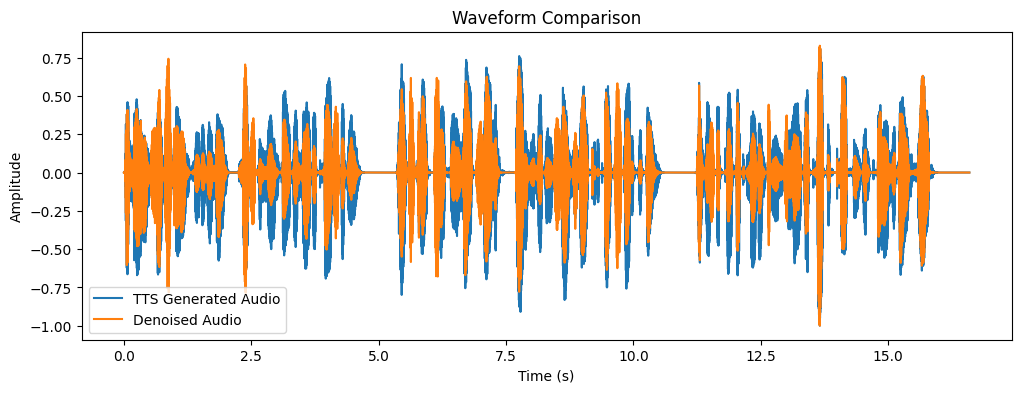

In [13]:
plot_waveforms(gen_tts_filename, denoised_filename)

## Compare with the Original Speaker Audio

In [14]:
def extract_features(path, sr=16000):
    y, sr = librosa.load(path, sr=sr, mono=True)

    # MFCCs (timbre)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = mfcc.mean(axis=1)

    # Pitch (F0)
    f0, _, _ = librosa.pyin(
        y,
        fmin=librosa.note_to_hz("C2"),
        fmax=librosa.note_to_hz("C7")
    )
    f0 = f0[~np.isnan(f0)]
    f0_mean = np.mean(f0) if len(f0) > 0 else 0

    # RMS energy
    rms = librosa.feature.rms(y=y).mean()

    # Spectral centroid (brightness)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()

    return np.concatenate([
        mfcc_mean,
        [f0_mean, rms, centroid]
    ])


In [15]:
def normalize(x, ref):
    return 1 - (np.abs(x - ref) / (np.abs(ref) + 1e-6))

def compare_audio_plots(
    speaker_wav,
    tts_wav,
    denoised_tts_wav,
    extra_wav=None,
    extra_label="Extra Audio"
):
    # Extract features
    ref = extract_features(speaker_wav)
    cand_a = extract_features(tts_wav)
    cand_b = extract_features(denoised_tts_wav)
    
    candidates = [cand_a, cand_b]
    labels = ["TTS Audio", "Denoised TTS Audio"]

    # Include extra file if provided
    if extra_wav is not None:
        cand_extra = extract_features(extra_wav)
        candidates.append(cand_extra)
        labels.append(extra_label)

    sims = [normalize(c, ref) for c in candidates]

    feature_labels = [f"MFCC{i}" for i in range(1, 14)] + ["Pitch", "Energy", "Brightness"]
    angles = np.linspace(0, 2*np.pi, len(feature_labels), endpoint=False)
    angles = np.concatenate([angles, [angles[0]]])  # Close the loop
    sims = [np.concatenate([s, [s[0]]]) for s in sims]  # Close the loop

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    
    colors = ["blue", "red", "green"][:len(labels)]
    for sim, lbl, color in zip(sims, labels, colors):
        ax.plot(angles, sim, label=lbl, color=color)
    
    ax.plot(angles, [1]*len(angles), linestyle="--", color="gray", label="Reference")
    ax.set_thetagrids(angles[:-1] * 180 / np.pi, feature_labels)
    ax.set_title("Feature Similarity to Reference (Higher is Better)")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=len(labels)+1)
    plt.show()


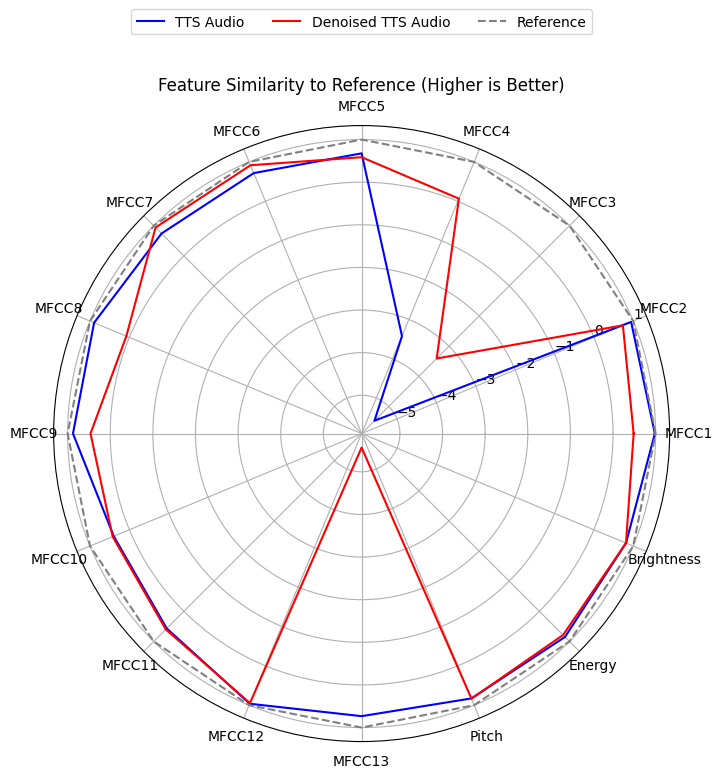

In [16]:
compare_audio_plots(speaker_wav, gen_tts_filename, denoised_filename)

The plot suggests that the denoising application did not improve the audio quality in terms of MFCC features; in particular, there is a noticeable degradation around MFCC coefficient 13, indicating that certain spectral characteristics may have been altered. Listening to the audio reveals a different story: perceptually, the denoised audio sounds cleaner and closer to the target speaker than the original TTS-generated audio, highlighting a gap between objective MFCC measurements and human auditory perception. This is as a result of the significant improvement in MFCC coefficient 3. MFCC coefficient 3 helps highlight pitch-related and harmonic content.

### Preserve Pitch and Harmonics in the Audio

In [17]:
def denoise_audio_v2(
    input_path,
    output_path,
    noise_duration=0.5,
    normalize=True
):
    """
    Denoise an audio file while preserving pitch and harmonic content.
    
    Args:
        input_path (str): Path to the input audio file.
        output_path (str): Path to save the cleaned audio.
        noise_duration (float): Duration (in seconds) to use for noise estimation.
        normalize (bool): Whether to normalize output audio.
        plot (bool): Whether to plot waveform comparison.
    """
    data, sr = sf.read(input_path)

    if len(data.shape) > 1:  # Stereo
        denoised = np.zeros_like(data)
        for ch in range(data.shape[1]):
            noise_sample = data[0:int(sr*noise_duration), ch]
            denoised[:, ch] = nr.reduce_noise(
                y=data[:, ch],
                y_noise=noise_sample,
                sr=sr,
                stationary=False  # preserves tonal content
            )
    else:  # Mono
        noise_sample = data[0:int(sr*noise_duration)]
        denoised = nr.reduce_noise(
            y=data,
            y_noise=noise_sample,
            sr=sr,
            stationary=False
        )

    if normalize:
        denoised = normalize_audio(denoised)

    sf.write(output_path, denoised, sr)
    print(f"Audio cleaned and saved as {output_path}")

In [ ]:
denoised_out = "./denoised"
os.makedirs(denoised_out, exist_ok=True)

denoised_filename_v2 = os.path.join(denoised_out, "lj001_0001_v2.wav")
denoise_audio_v2(gen_tts_filename, denoised_filename_v2)

Audio cleaned and saved as ./denoised/lj001_0001_v2.wav


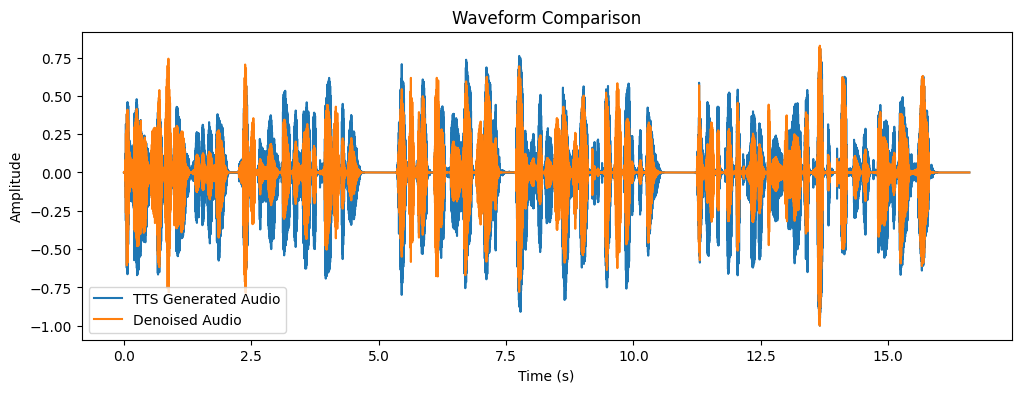

In [19]:
plot_waveforms(gen_tts_filename, denoised_filename_v2)

In [20]:
Audio(denoised_filename_v2)

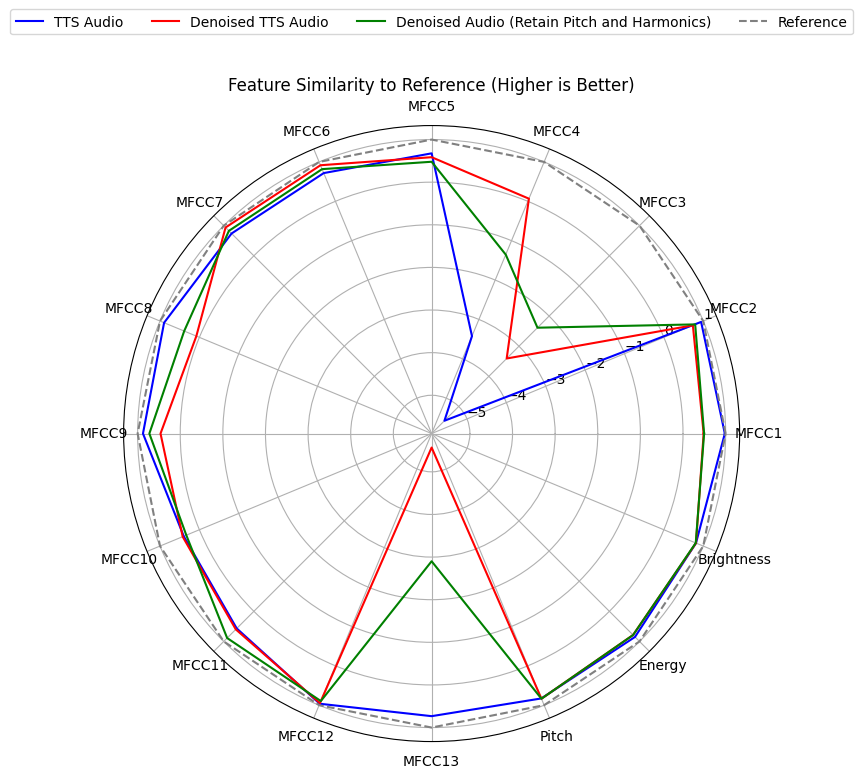

In [21]:
compare_audio_plots(
    speaker_wav, 
    gen_tts_filename, 
    denoised_filename,
    denoised_filename_v2,
    "Denoised Audio (Retain Pitch and Harmonics)"
)

By preserving the harmonics and pitch, we were able to improve MFCC coefficients 2 and 5. Listening to the audio confirms that the resulting speech is much closer to the target speaker, sounding significantly better than both the original TTS-generated audio and the initially denoised TTS output.

## Try Out French Language

In [ ]:
# Generated by chatGPT
fr_text = """
Le matin se leva doucement sur la ville. Les rayons du soleil traversaient les fenêtres, illuminant les rues calmes. Les oiseaux chantaient et les passants se pressaient pour commencer leur journée. C’était le moment idéal pour savourer un café et profiter de la tranquillité avant le tumulte de la ville.
"""

out_file_name_fr = "lj001_0001_fr.wav"
gen_tts_filename_fr = os.path.join(out_dir, out_file_name_fr)
tts = TTS(model)
tts.tts_to_file(
    text=text, file_path=gen_tts_filename_fr, language="fr-fr", speaker_wav=speaker_wav
)

 > tts_models/multilingual/multi-dataset/your_tts is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-

'./example_output/lj001_0001_fr.wav'

In [23]:
Audio(gen_tts_filename_fr)

In [24]:
denoised_filename_fr_v2 = "./denoised/lj001_0001_fr_v2.wav"
denoise_audio_v2(gen_tts_filename_fr, denoised_filename_fr_v2)

Audio cleaned and saved as ./denoised/lj001_0001_fr_v2.wav


In [25]:
Audio(denoised_filename_fr_v2)

## Future Work
Future developments for this project could focus on improving the fidelity of TTS audio to more closely match the target speaker. This includes creating a deep learning-based enhancement model to refine generated TTS, developing a high-quality speaker encoder to generate robust embeddings for speaker-guided synthesis, improving the TTS prosody, and enhancing the denoising pipeline to preserve speaker identity using MFCC- or embedding-based spectral shaping. Additionally, deploying the system across web, desktop, and mobile platforms would make it accessible to end-users, while incorporating objective and subjective evaluation metrics would provide systematic assessment of voice similarity and quality.